## Set up

Set Filepaths
Import packages



In [9]:
# set filepaths
path_to_raw = '../data/raw/'

# import packages - general
import numpy as np
import pandas as pd

# import packages - geospatial
import xarray as xr

# import packages - plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Read in data

In [14]:
# set datafiles
datafiles = ['era5_mslp_sst.nc', 'era5_sp_sst.nc']

# read in datafiles, combine into one dataset
for i in range(len(datafiles)):
    print("Loading datafile: ", datafiles[i])

    # if it's the first file, make it a dataset. Else, just add it on
    if i==0:
        ds = xr.open_dataset(path_to_raw + datafiles[i])
    else:
        ds = xr.merge([ds, xr.open_dataset(path_to_raw + datafiles[i])])


Loading datafile:  era5_mslp_sst.nc
Loading datafile:  era5_sp_sst.nc


In [15]:
# check we've got what we think we should
ds.head()

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, time: 5)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 1.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 89.0
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 1940-05-01
Data variables:
    msl        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 271.5 271.5 ... 271.5 271.5
    sp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-07 20:57:32 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Clean Data - Check for nan values\

There are no nan vlaues except in the sst field. These likely represent temperatures over land. No additional cleaning is needed here.

In [4]:
# takes a while, so I've included a toggle to swtich this on and off
if False:
    # Check for NaN values in the specified fields
    nan_sst = ds['sst'].isnull().sum().item()
    nan_msl = ds['msl'].isnull().sum().item()
    nan_sp = ds['sp'].isnull().sum().item()
    nan_z = ds['z'].isnull().sum().item()

    print(f"NaN values in 'sst': {nan_sst}")
    print(f"NaN values in 'msl': {nan_msl}")
    print(f"NaN values in 'sp': {nan_sp}")
    print(f"NaN values in 'z': {nan_z}")

## Clean Data - Remove lakes and non-ocean water from SST dataset

I don't want to include these when thinking about ocean temperature.

Here I use the GEBCO bathymetry dataset to mask out the land areas.
 - First, I read in the dataset
 - Next I resample to match the spatial resolution of the ERA5 data in my xarray ds
- Next, I apply a filter for bathymetry below sea level (-5m) to identify ocean areas.
 - Next, I set the SST field to nan for all values where the GEBCO file is deeper than the -5m threshold

In [4]:
# This works in theory (I think), but is VERY slow due to the super high resolution gebco dataset.
if False:

    # Read in GEBCO bathymetry dataset
    gebco_path = path_to_raw + 'GEBCO_2024.nc'
    gebco_ds = xr.open_dataset(gebco_path)

    # switch gebco_ds longitude values which are less than 0 to be 0-360
    #ds2 = gebco_ds.assign_coords(lon=(gebco_ds.coords['lon'].values + 360)%360)
    gebco_ds['lon'] = (gebco_ds['lon'] + 360) % 360
    gebco_ds = gebco_ds.sortby('lon')

    # resample to era5 grid
    elevation = gebco_ds.interp(lat=ds['latitude'], lon=ds['longitude'], method='nearest')


    # Set the SST field to NaN for all values where the GEBCO file is deeper than the -5m threshold
    ocean_mask = elevation < -5

    # Set the SST field to NaN for all values where the GEBCO file is deeper than the -5m threshold
    ds['sst'] = ds['sst'].where(ocean_mask, other=np.nan)


In [12]:
# for now, just using a lower resolution solution
from global_land_mask import globe

# Apply the is_ocean function to the entire xarray dataset
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

# Create a mask for ocean points
print('making mask')
ocean_mask = np.array([[globe.is_ocean(lat, lon) for lon in ((longitudes + 180) % 360) - 180] for lat in latitudes])

# Apply the mask to the SST field
print('applying mask')
ds['sst'] = ds['sst'].where(ocean_mask, other=np.nan)

making mask
applying mask


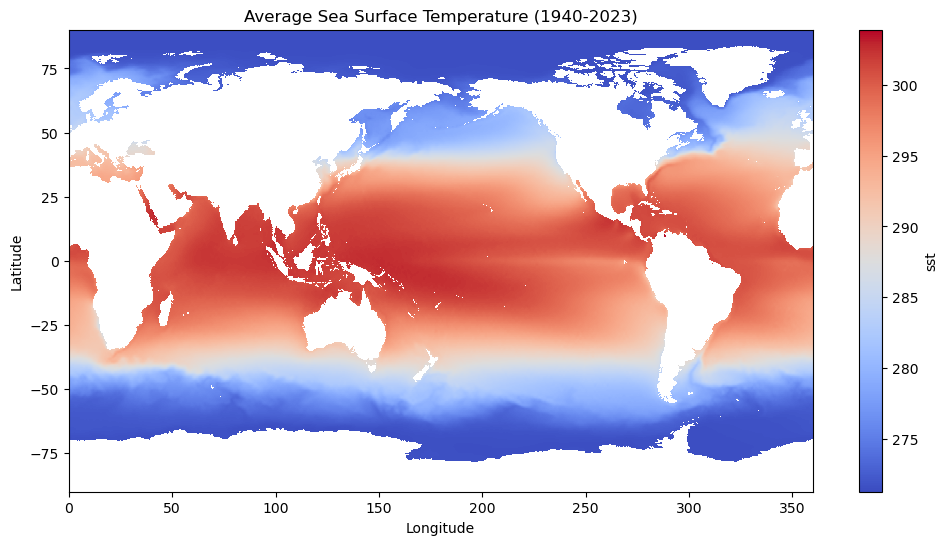

In [13]:
# Plot SSTs to confirm the above approach worked - it does! No more lakes!

# Calculate the average SST over the entire time period
sst_mean = ds.sst.mean(dim='time')

# Plot the global map of the average SST
plt.figure(figsize=(12, 6))
sst_mean.plot(cmap='coolwarm')
plt.title('Average Sea Surface Temperature (1940-2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Save data now that it's Cleaned

In [28]:
# save to file
ds.to_netcdf('../data/cleaned/era5.nc')